## Projet -- Introduction à l’apprentissage profond

Par **Mohamed Massamba Sene**

### Partie 1 : Perceptron

Indiquer et expliquer la taille de chaque tenseur dans le fichier perceptron_pytorch.py

- data_train est un tenseur de taille (63000, 784) -- ceci est dû au fait qu'il contient 90% des examplaires du dataset inital et pour chaque exemplaire il s'agit d'une image de dimension 28x28 pixels qui étalé donne un vecteur (784,) nous avons donc 63000 images chacune de (784,) ce qui nous donne donc 63000 lignes et 784 colonnes d'où notre tenseur de dimension (63000, 784)

- data_test est un tenseur de taille (7000, 784) -- ceci est dû au fait qu'il contient 10% des examplaires du dataset inital et pour chaque exemplaire il s'agit d'une image de dimension 28x28 pixels qui étalé donne un vecteur (784,) nous avons donc 7000 images chacune de dimension (784,) ce qui nous donne 7000 lignes et 784 colonnes d'où notre tenseur de dimension (7000, 784)

- label_train est un tenseur de taille (63000, 10) -- ceci est dû au fait qu'il contient 10% des labels du dataset inital (ceux associés aux exemplaires du data_train en l'occurence) et pour chaque exemplaire il s'agit d'un vecteur one hot encoded du label sachant qu'il y a 10 classes possibles donc de dimension (10,), nous avons alors 63000 labels de dimension (10,) ce qui nous donne le tenseur de taille (63000, 10)

- label_test est un tenseur de taille (7000, 10) -- ceci est dû au fait qu'il contient 10% des labels du dataset inital (ceux associés aux exemplaires du data_test en l'occurence) et pour chaque exemplaire il s'agit d'un vecteur one hot encoded du label sachant qu'il y a 10 classes possibles donc de dimension (10,), nous avons alors 7000 labels de dimension (10,) ce qui nous donne le tenseur de taille (63000, 10)

- w est un tenseur de taille (784, 10) -- Ce tenseur représente les poids associés aux entrées de nos neurones. Pour chaque neurone nous avons 784 variables en entrées (représentant les 784 pixels de nos images) et avons 10 neurones au total (un pour chacune des classes possibles) afin de nous permettre d'avoir en sortie notre vecteur de 10 variables chacune étant la sortie associée à cette classe. Nous avons donc un tenseur (784, 10) pour notre tenseur des poids.

- b est un tenseur de taille (1, 10) -- Ce tenseur représente les biais de nos neurones. En effet comme mentionné précédemment nous avons 10 neurones (un pour chacune des classes possibles) et pour chacun de ces neurones nous associons un biais à sa sortie. Nous avons donc un tenseur (1,10) pour notre tenseur des biais.

- indices est un tenseur de taille (63000,) -- Il s'agit juste d'une liste contenant un indice associé à chaque exemplaire de notre jeu d'entrainement (data_train)

- x est un tenseur de taille (5, 784) -- Ce tenseur est le résultat d'un batch cad que l'on choisit un ensemble d'exemplaires parmi ceux de notre jeu d'entrainement (data_train). La taille du batch ayant été fixé à 5, on a donc 5 exemplaires d'images chacune de dimension (784,) d'où la taille de (5,784)

- y est un tenseur de taille (5, 10) -- Il s'agit du label prédit pour chaque exemplaire de notre de batch, le label étant la prédiction issue de notre neurone donc un vecteur de dimension (10, ). Nous avons donc 5 prédictions chacune de dimension (10,) d'où la taille de (5,10)

- t est un tenseur de taille (5,10) -- Il s'agit des labels réels associés aux emplaires de notre mini batch donc nous avons 5 exemplaires chacune de dimension (10,) d'où la taille de (5,10)

- grad est un tenseur de taille (5, 10) -- Il s'agit du résultat de la soustraction entre t et y deux tenseurs de taille (5,10) donc il est également de taille (5,10)

### Partie 2 : Shallow Network

In [1]:
import torch
import numpy as np
import gzip
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
import pandas as pd
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary
import random

In [2]:
# Chargement des données
((data_train,label_train),(data_test,label_test)) = torch.load(gzip.open('mnist.pkl.gz'))

### Partie 2 : Shallow network

####  Implémentez un perceptron multi-couche avec PyTorch

In [3]:
def init_weights_bias(layer):
    """
        Cette fonction permet d'initialiser les poids and biais des couches de notre perceptron multi-couches
        Elle prend une couche en entrée, vérifie qu'il s'agit d'une couche dense et applique l'initialisation si tel est le cas
    """
    if isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight,mean=0, std=0.01)
        nn.init.zeros_(layer.bias)

In [4]:
import torch.utils
import torch.utils.data

class MultiLayerPerceptron():

    """
        Cette classe nous permet de créer et entrainer notre perceptron mutli-couche
    """

    def __init__(self, n_networks_hidden):
        super().__init__()
        self.multilayer_perceptron = nn.Sequential(
            nn.Linear(784, n_networks_hidden),
            nn.ReLU(),
            nn.Linear(n_networks_hidden, 10)
        )
        # Intialisation aléatoire des poids du modèles
        self.multilayer_perceptron.apply(init_weights_bias)
        
    
    def train(self, train_data, test_data, epochs, lr, *, batch_size=5, patience=2):
        # Création des lecteurs de données
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
        # Définition de la fonction coût et de l'optimiseur
        loss_func = nn.MSELoss()
        optim = torch.optim.SGD(self.multilayer_perceptron.parameters(), lr=lr)
        # Variables pour l'early stopping
        prev_acc = 0.0
        no_improve_epochs = 0
        # Entrainement pour le nombre d'epochs défini
        for n in range(epochs):
            # Chargement des tuples (data, label) du train set
            for x,t in train_loader:
                # Prediction et mise à jour des poids
                y = self.multilayer_perceptron(x)
                loss = loss_func(t,y)
                loss.backward()
                optim.step()
                optim.zero_grad()
            # Evaluation lors de l'apprentissage
            acc = 0.
            count = 0
            # Chargement des tuples (data, label) du test set
            with torch.no_grad():
                for x,t in test_loader:
                    # Prediction et mise à de l'accuracy
                    y = self.multilayer_perceptron(x)
                    acc += torch.argmax(y,1) == torch.argmax(t,1)
                    count += 1
                current_acc = acc / count
                # --------------------------------------------------------------------------------------------  #
                # Early stopping nous permet d'arrêter l'entraînement d'un modèle lorsque les perfomances       #
                # cessent de s'améliorer sur un certain nombre d'epochs consécutifs (patience) afin d'éviter    #
                # l'overfitting et économiser en terme de ressources de calcul                                  #
                # --------------------------------------------------------------------------------------------  #
                if (current_acc-prev_acc) > 0:
                    no_improve_epochs = 0 
                else:
                    no_improve_epochs += 1
                prev_acc = current_acc
                if no_improve_epochs >= patience:
                    break
        # Renvoie du pourcentage de bonnes réponses
        return acc/count

train_dataset = torch.utils.data.TensorDataset(data_train,label_train)
test_dataset = torch.utils.data.TensorDataset(data_test,label_test)
model = MultiLayerPerceptron(128)
score = model.train(train_dataset, test_dataset, 10, 0.001)

print(f"La précision du modèle après entrainement est {score[0]:.2f}")

La précision du modèle après entrainement est 0.88


#### Décrivez très précisément la méthodologie à utiliser pour trouver les bons hyperparamètres pour avoir la meilleure performance.
Pour déterminer les hyperparamètres optimaux, on peut adopter une approche itérative. On démarre avec un large espace par explorer les combinaisons d'hyperparamètres dans un large espace pour capturer des comportements globaux et obtenir les hyperparamètres qui semble les plus prometteurs. Puis à chaque nouvelle itération, on affine l'espace de recherche autour de ces hyperparamètres jusqu'à atteindre les valeurs optimales. Nous présentons cet approche ci-dessous:

1. Commencer par définir un large éventail de valeurs possibles pour chaque hyperparamètre. Par exemple nous pourrions avoir les valeurs possibles suivantes pour ces hyperparamètes
```python
etas = [0.001, 0.002, 0.004, 0.006, 0.008, 0.01, ....]
n_hiddens = [32, 64, 96, 128, 156, 192, ...]
batch_sizes = [5, 10, 15, 20, 25, 30, ...]
```
2. Itération 0 : Exploration de l'espace des hyperparamètres
    * Effectuer une recherche aléatoire dans cet espace de recherche large en générant un ensemble de combinaisons d'hyperparamètres en prenant une valeur pour chaque hyperparamètre de façon aléatoire
    * Entraîner le modèle avec ces combinaisons et évaluer les performances pour trouver le meilleur modèle parmi ceux testés
3. Itérations 1 à n : Affinage de l'espace de recherche et optimisation de la performance
    * Affiner l'espace de recherche avec des valeurs centrés autour des meilleurs hyperparamètres trouvés lors de l'itération précédente
        Pour ce faire nous prenons les valeurs voisines de la valeur précédemment trouvée et créons l'espace à partir de valeurs contenues entre les deux en définissant l'incrément comme l'espace entre la borne inférieure et la borne supérieure divisé par le nombre de valeurs que l'on souhaite tester. Ceci nous permet à chaque itération de nous concentrer autour des valeurs les plus prometteuses
    * Effectuer une recherche aléatoire dans cet espace de recherche en générant un ensemble de combinaisons d'hyperparamètres en prenant une valeur pour chaque hyperparamètre de façon aléatoire
    * Entraîner le modèle avec ces combinaisons et évaluez les performances pour trouver le meilleur modèle parmi ceux testés
    * Comparer les performances du meilleur modèle trouvé lors de cette itération avec celles du modèle précédent. 
        * Si le modèle est amélioré, répéter
        * Sinon, arrêter la recherche.

NB: Les modèles sont testés et comparés sur le validation set (différent du jeu d'entrainement et du jeu de test)<br/>
A la fin de ces itérations on obtient donc les hyperparamètres optimaux et le meilleur modèle obtenu est évalué sur le jeu de test.

#### Trouvez des hyperparamètres permettant d’avoir une bonne performance en expliquant/justifiant sur quels tests vous vous êtes concentrés

Disposant d'un Apple Silicon M2, après plusieurs recherches nous avons considéré que nous serions capables de tester un nombre relativement large de combinaisons dans la mesure où c'est processeur très performant bien qu'inférieur aux GPUs spécialisés. <br/>
- Initialisation des valeurs possibles de chaque hyperparamètre<br/>
Nous avons défini pour chaque hyperparamètre, son espace de recherche de façon suffisamment large capturer des comportements globaux du modèle.<br/>
Par example pour le learning rate nous allons de 10e-4 à 10e-1, ce qui nous permet essentiellement de capturer le comportement du modèle pour des taux faibles tout comme pour des taux importants. Et nous procédons de même pour le nombre de neurones de la couche caché (64 à 256 par pas de 32) afin d'avoir des complexités de modèle suffisamment diversifiée ainsi que pour le batch_size (8 à 64 par de 8)
- Choix du nombre de combinaisons générées à l'itération 0<br/>
En effet notre espace de recherche est très vaste, nous avons 4 valeurs possibles du learning_rate, 12 valeurs possibles du nombre de neurones et 7 valeurs possibles du batch_size. Ceci nous donne 336 combinaisons possibles au total. Cependant tester toutes ces combinaisons serait très couteux en terme de puissance de calcul. Comme mentionné plus haut nous générons nos combinaisons, en sélectionnant de façon aléatoire une valeur de chaque hyperparamètre sur tout l'espace ce qui permet en théorie d'explorer suffisamment l'espace de recherche sans tester toutes les combinaisons possibles. La M2 disposant de performances élevées en terme de calcul, nous avons jugé que nous serions en mesure de tester 100 combinaisons au niveau de cette itération, nous permettant ainsi une exploration exhaustive de l'espace de recherche tout en restant dans les limites de notre puissance de calcul afin d'obtenir un bon aperçu sur les comportements globaux
- Choix du nombre d'itérations<br/>
Avec chaque itération, l’espace de recherche est affiné autour des meilleures performances précédemment observées, réduisant ainsi le besoin d'explorer l’intégralité de l’espace. Nous jugeons que 3 itérations permettent de capturer la dynamique de convergence des hyperparamètres tout en restant dans les contraintes de calcul. Et nous avons eu à constater en pratique que ce choix donnait des résultats suffisants.
- Affinage de l'espace de recherche<br/>
Pour affiner l'espace de recherche, nous avons choisi de prendre 6 valeurs autour des bornes supérieure et inférieure de chaque hyperparamètre. Nous avons trouvé que ce choix permet de se concentrer sur les zones les plus prometteuses de l’espace de recherche tout en maintenant une bonne distance entre chaque valeur.
- Choix du nombre de combinaisons générées à chaque itération 1 à 5<br/>
Etant donné que l’espace de recherche est restreint, le nombre total de combinaisons possibles est réduit à 216 et un plus petit nombre de combinaisons est nécessaire pour explorer efficacement la zone. Nous avons opté pour 30 combinaisons afin de suffisamment exploré l'espace tout en respectant les limites de calcul disponibles sur notre ordinateur.

In [5]:
def create_random_combinations(params_dict, n_combinations):
    """ 
        Cette fonction nous permet de générer aléatoirement n_combinaisons d'hyperparamètres
    """
    n_comb = 0
    all_combs = []
    while n_comb < n_combinations:
        comb = dict()
        for key in params_dict:
            value = random.choice(params_dict[key])
            comb[key] = value
        if not comb in all_combs:
            all_combs.append(comb)
            n_comb+=1
    return all_combs

def refine_lr_range(initial_space,learning_rate, *, n_values=6):
    """
        Cette fonction nous permet d'affiner l'espace de recherche pour le learning rate en définissant l'espace de recherche par rapport aux valeurs voisines du meilleur hyperparamètre précédemment trouvé.
        Pour ce faire nous divisons l'espace entre la borne sup et la borne inf par le nombre de valeurs voulues.
    """    
    # Trouver l'index de la valeur du learning_rate
    idx = initial_space.index(learning_rate)
    
    # Sélectionner les voisins si disponibles
    min_lr = initial_space[max(0, idx - 1)]
    max_lr = initial_space[min(len(initial_space) - 1, idx + 1)] 
    
    # Calcul de l'incrément
    lr_increment = (max_lr - min_lr) / (n_values - 1)
    
    # Générer les valeurs voisines entre min_lr et max_lr
    return [min_lr + (lr_increment * i) for i in range(n_values)]

def refine_hidden_range(initial_space, n_hiddens, *, n_values=6):
    """
        Cette fonction nous permet d'affiner l'espace de recherche pour le nombre de neurones d'une couche cachée en définissant l'espace de recherche par rapport aux valeurs voisines du meilleur hyperparamètre précédemment trouvé.
        Pour ce faire nous divisons l'espace entre la borne sup et la borne inf par le nombre de valeurs voulues.
    """
    # Trouver l'index de la valeur du learning_rate
    idx = initial_space.index(n_hiddens)
    
    # Sélectionner les voisins si disponibles
    min_lr = initial_space[max(0, idx - 1)]
    max_lr = initial_space[min(len(initial_space) - 1, idx + 1)] 
    
    # Calcul de l'incrément
    lr_increment = (max_lr - min_lr) / (n_values - 1)
    
    # Générer les valeurs voisines entre min_lr et max_lr
    return [int(round(min_lr + (lr_increment * i))) for i in range(n_values)]

def refine_batch_size(initial_space, batch_size, *, n_values=6):
    """
        Cette fonction nous permet d'affiner l'espace de recherche pour le batch_size en définissant l'espace de recherche par rapport aux valeurs voisines du meilleur hyperparamètre précédemment trouvé.
        Pour ce faire nous divisons l'espace entre la borne sup et la borne inf par le nombre de valeurs voulues.
    """
    # Trouver l'index de la valeur du learning_rate
    idx = initial_space.index(batch_size)
    
    # Sélectionner les voisins si disponibles
    min_lr = initial_space[max(0, idx - 1)]
    max_lr = initial_space[min(len(initial_space) - 1, idx + 1)] 
    
    # Calcul de l'incrément
    lr_increment = (max_lr - min_lr) / (n_values - 1)
    
    # Générer les valeurs voisines entre min_lr et max_lr
    return [int(round(min_lr + (lr_increment * i))) for i in range(n_values)]

In [6]:
# Définition de l'espace de recherche pour nos hyperparamètres
params_dict = dict()

params_dict['lr'] = np.logspace(-4, -1, 4).tolist()
params_dict['n_hidden'] = list(range(64, 256, 32))
params_dict['batch_size'] = list(range(8, 64, 8))

# Séparation des données du train set initial en train (80%) et validation set (20%)
train_data, val_data, train_labels, val_labels = train_test_split(data_train, label_train, test_size=.2)

# Création du train set et du validation set
train_dataset = torch.utils.data.TensorDataset(data_train,label_train)
val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)

# Création du test set
test_dataset = torch.utils.data.TensorDataset(data_test, label_test)

# Initialisation de la liste pour stocker les résultats des diverses combinaisons
data = []

In [7]:
# Création de la grille de paramètres (Liste de toutes les combinaisons de valeurs possibles)
combinations = create_random_combinations(params_dict, 100)

# Nombre d'itération voulues
n_iterations = 3

# Itération 0:  Exploration de l'espace des hyperparamètres

# Initialisation du best_score et best_model
best_score = 0
best_model = None
best_combination=None
# Test de toutes les combinaisons de valeurs obtenus
for combination in combinations:
    # Initialisation du model avec les params de la combinaison
    model = MultiLayerPerceptron(combination['n_hidden'])
    # Entrainement du model avec les params de la combinaison
    score = model.train(train_dataset, val_dataset, 10, combination['lr'], batch_size=combination['batch_size'])
    # Ajout des résultats obtenus avec cette combinaison à liste des résultats
    combination['score'] = round(float(score[0]), 4)
    data.append(combination)
    # Mise à jour du meilleur modèle et score obtenu s'il y a lieu
    if score > best_score:
        best_score = score
        best_model = model
        best_combination = combination

# Itération 1 à 3:  Affinage de l'espace de recherche et optimisation de la performance
for i in range(n_iterations):
    initial_best = best_combination
    # Affiner l'espace de recherche à partir de la meilleure combinaison trouvée
    params_dict['lr'] = refine_lr_range(params_dict['lr'], best_combination['lr'])
    params_dict['n_hidden'] = refine_hidden_range(params_dict['n_hidden'], best_combination['n_hidden'])
    params_dict['batch_size'] = refine_batch_size(params_dict['batch_size'], best_combination['batch_size'])
    # Générer un ensemble de combinaison
    combinations = create_random_combinations(params_dict, 30)
    # Tester toutes les combinaisons de valeurs générées
    for combination in combinations:
        model = MultiLayerPerceptron(combination['n_hidden'])
        score = model.train(train_dataset, val_dataset, 10, combination['lr'], batch_size=combination['batch_size'])
        combination['score'] = round(float(score[0]), 4)
        data.append(combination)
        # Mettre à jour le meilleur modèle s'il y a lieu
        if score > best_score:
            best_score = score
            best_model = model
            best_combination = combination
    # Vérifier critère d'arrêt (l'affinage de l'espace ne conduit pas à  un meilleur modèle)
    if best_combination == initial_best:
        break

In [8]:
# Création d'un dataframe à partir de la liste des résultats pour visualisation et suppression des duplicatats
df_grid_search = pd.DataFrame(data)
df_grid_search = df_grid_search.drop_duplicates()
df_grid_search

,lr,n_hidden,batch_size,score
0,0.01000,224,24,0.9106
1,0.10000,224,32,0.9689
2,0.10000,224,8,0.9826
3,0.10000,128,32,0.9635
4,0.01000,128,32,0.8913
...,...,...,...,...
185,0.09784,220,8,0.9832
186,0.09640,220,8,0.9824
187,0.09784,216,8,0.9825
188,0.09640,214,8,0.9829


In [9]:
# Affichage de la combinaison d'hyperparamètres présentation le meilleur score
best_combination = df_grid_search.iloc[df_grid_search['score'].idxmax()]
print(f"La meilleure combinaison d'hyperparamètres est\n {best_combination}")

La meilleure combinaison d'hyperparamètres est
 lr              0.1000
n_hidden      218.0000
batch_size      8.0000
score           0.9845
Name: 171, dtype: float64


In [10]:
# Vérification de la précision du meilleur modèle obtenu sur le test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
acc = 0.
count = 0
with torch.no_grad():
    for x,t in test_loader:
        y = best_model.multilayer_perceptron(x)
        acc += torch.argmax(y,1) == torch.argmax(t,1)
        count += 1
    test_score =acc/count
print(f"La précision du meilleur modèle sur le test set est: {test_score[0]:.4f}")

La précision du meilleur modèle sur le test set est: 0.9816


In [11]:
# Affichage du modèle 
summary(best_model.multilayer_perceptron, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 218]                 171,130
├─ReLU: 1-2                              [-1, 218]                 --
├─Linear: 1-3                            [-1, 10]                  2,190
Total params: 173,320
Trainable params: 173,320
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.66
Estimated Total Size (MB): 0.67


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 218]                 171,130
├─ReLU: 1-2                              [-1, 218]                 --
├─Linear: 1-3                            [-1, 10]                  2,190
Total params: 173,320
Trainable params: 173,320
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.66
Estimated Total Size (MB): 0.67

#### Visualisation de l'influence des hyperparamètres

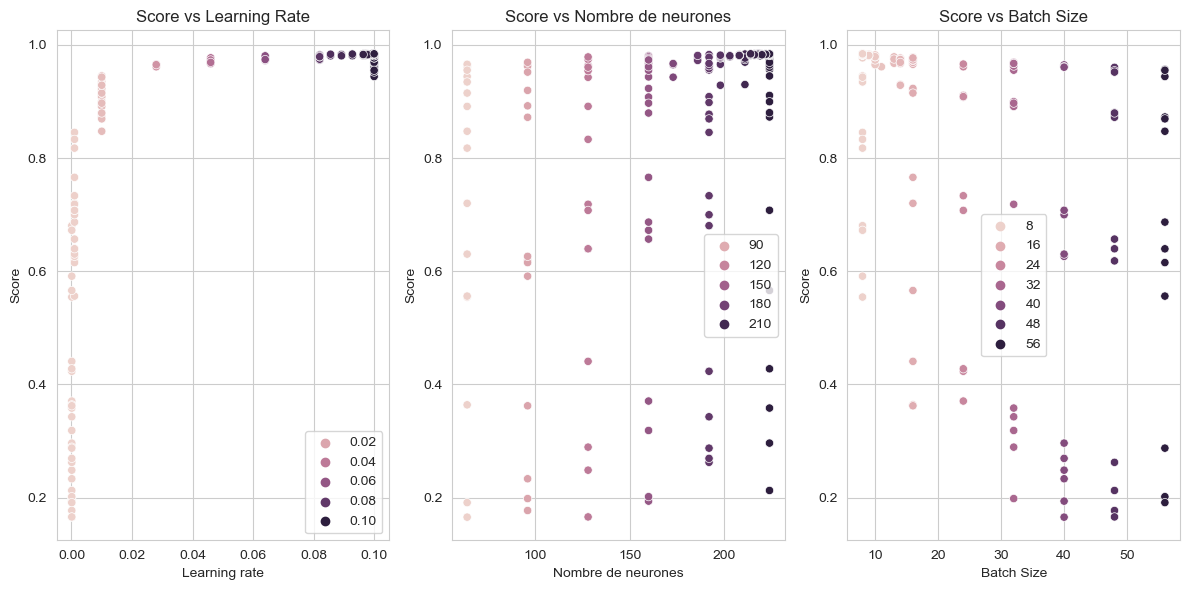

In [12]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))

# Influence du learning rate sur le score en fonction du batch_size 
plt.subplot(1, 3, 1)
sns.scatterplot(x='lr', y='score', data=df_grid_search, hue="lr")
plt.title('Score vs Learning Rate')
plt.xlabel('Learning rate')
plt.ylabel('Score')
plt.legend()

# Influence du nombre de neurone de la couche cachée sur le socre
plt.subplot(1, 3, 2)
sns.scatterplot(x='n_hidden', y='score', data=df_grid_search, hue='n_hidden')
plt.title('Score vs Nombre de neurones')
plt.xlabel('Nombre de neurones')
plt.ylabel('Score')
plt.legend()

# Influence du batch_size sur le score
plt.subplot(1, 3, 3)
sns.scatterplot(x='batch_size', y='score', data=df_grid_search, hue='batch_size')
plt.title('Score vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

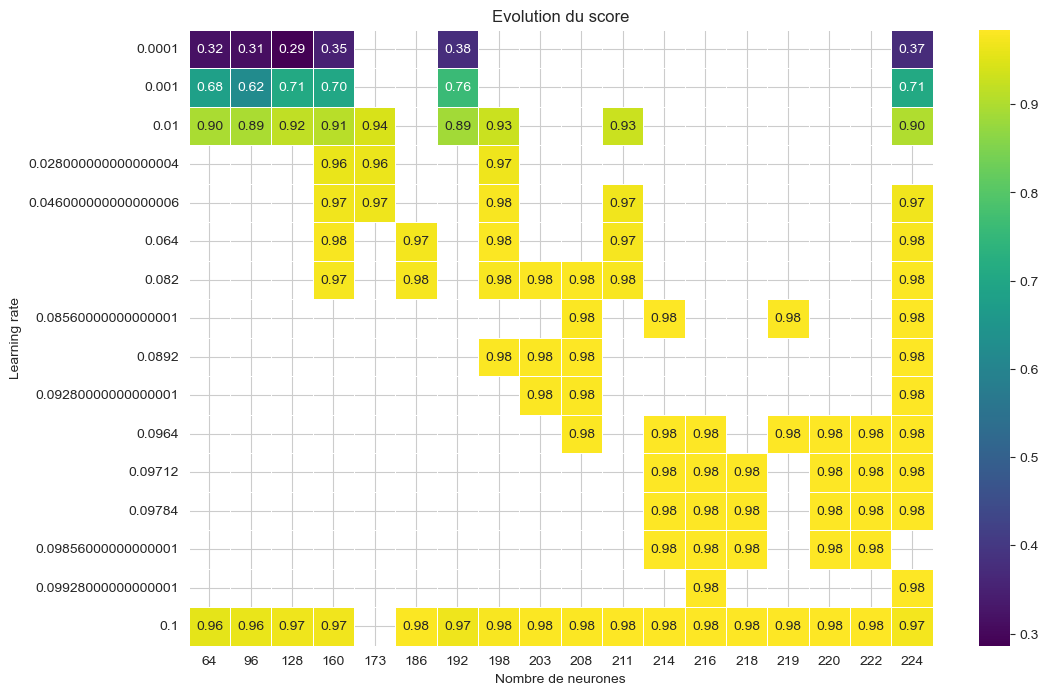

In [13]:
sns.set_style('whitegrid')

# Evolution du score par rapport au learning rate et au nombre de neurones de la couche cachée
pivot_table = df_grid_search.pivot_table(values='score', index='lr', columns='n_hidden')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Evolution du score')
plt.xlabel('Nombre de neurones')
plt.ylabel('Learning rate')
plt.show()

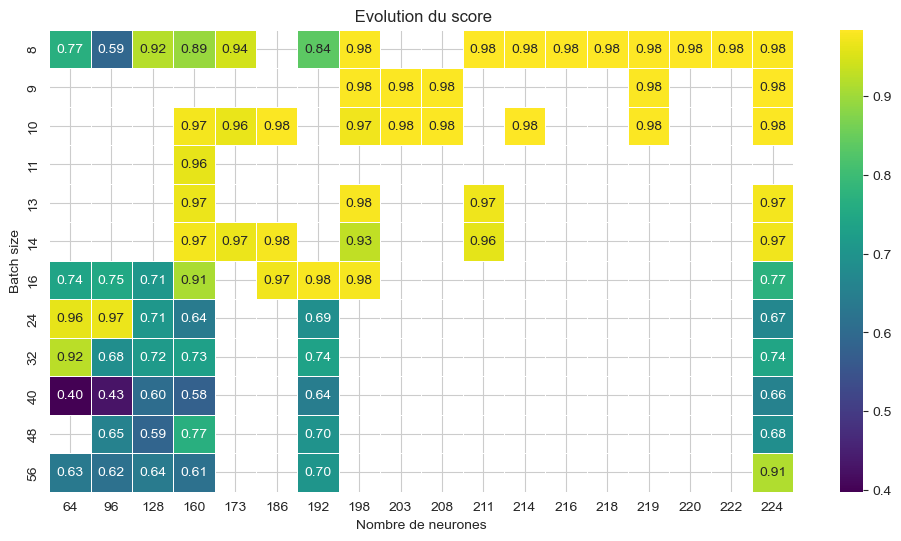

In [14]:
sns.set_style('whitegrid')

# Evolution du score par rapport au batch_size et au nombre de neurones de la couche cachée
pivot_table = df_grid_search.pivot_table(values='score', index='batch_size', columns='n_hidden')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title(' Evolution du score')
plt.xlabel('Nombre de neurones')
plt.ylabel('Batch size')
plt.show()

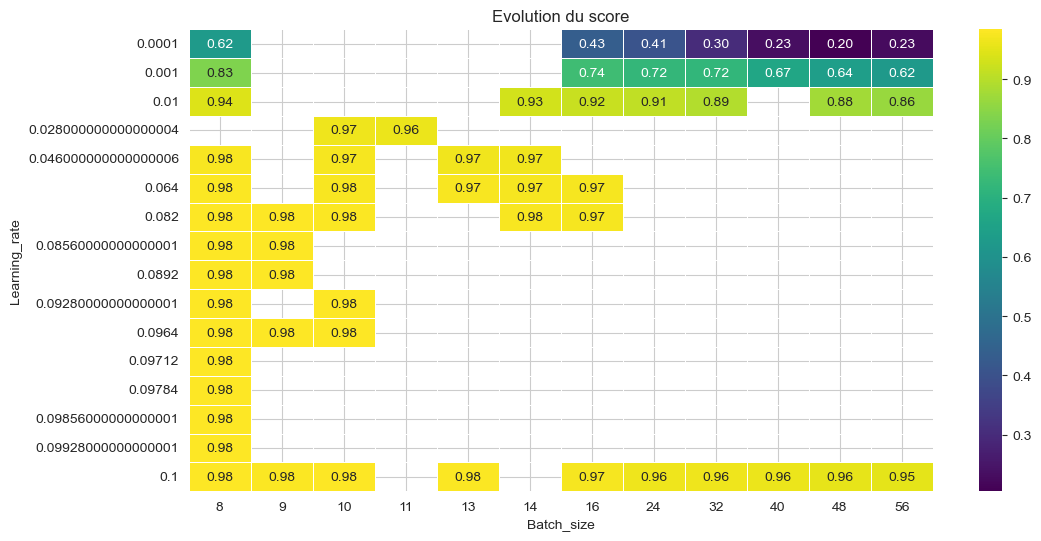

In [15]:
sns.set_style('whitegrid')

# Evolution du score par rapport au learning rate et au batch_size
pivot_table = df_grid_search.pivot_table(values='score', index='lr', columns='batch_size')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Evolution du score')
plt.xlabel('Batch_size')
plt.ylabel('Learning_rate')
plt.show()

#### Décrire l'influence des hyperparamètres

Ceci nous permet donc d'optimiser les hyperparamètres tout en tenant compte des contraintes de calcul disponibles, le tout ayant été exécuté en 43 minutes lors de l'expérimentation avec une performance de notre meilleur modèle sur le test set s'élevant à 0.9816.

Nous pouvons observer au travers de l'évolution de la performance par rapport à la variation des hyperparamètres que:
- $\eta$<br/>
Nous pouvons constater une tendance générale de l'augmentation du score à mesure que le learning rate augmente. Plus particulièrement:
    - Pour $\eta \lt 0.01$, les scores sont généralement faibles, surtout pour $\eta = 0.0001$ où la meilleure performance noté est de 0.62. Cependant, à mesure que le learning rate augmente, les performances du modèle augmentent atteingant un meilleur score de 0.83 pour $\eta = 0.001$, indépendamment de la configuration des autres hyperparamètres.
   - Pour $\eta \geq 0.01$, les performances sont meilleures À partir de cette valeur, les scores atteignent ou dépassent souvent 0.9, quelles que soient les autres hyperparamètres du modèle. Cela montre que pour un learning rate plus élevé, la performance est généralement bonne et se stabilise autour de 0.97 à 0.98 au-delà de 0.04 où l'on ne note plus d'amélioration significative.<br/>
En effet, un learning rate trop bas entraîne des progrès lents dans l'optimisation limitant la capacité du modèle à bien s'ajuster aux données. En revanche avec des learning rate plus élevé on arrive à atteindre rapidement un bon optimum sans dépasser les bonnes solutions, d'où des performances plus élevées avec une stabilisation au delà de 0.06. Cependant un learning rate trop élevé peut conduire à des oscillations ou à une divergence dans l'apprentissage, donc vu les résultats obtenus augmenter davantage pourrrait entrainer une divergence.
- Nombre de neurones<br/>
Nous pouvons constater une tendance générale de l'augmentation du score à mesure que le nombre de neurones de la couche cachée augmente. Les meilleurs scores sont observés pour un nombre de neurones compris entre 198 et 222, après quoi une légère baisse de la performance peut être notée. On note également que pour des petites tailles de batch (8-14), la performance du modèle augmente avec le nombre de neurones. Toutefois pour des tailles de batch plus grandes l'évolution des performances devient plus variée, sans tendance clairement définie.<br/>
En effet un nombre de neurones de la couche cachée trop faible limite la capacité du modèle à capter des patterns complexes dans les données, tandis qu'un nombre de neurones trop élevé peut entraîner une surapprentissage. Les résultats semblent montrer qu'un nombre entre 198 et 222 offre un bon équilibre entre la capacité de représentation et la généralisation.
- Batch Size<br/>
Nous pouvons constater une tendance générale de baisse du score à mesure que le nombre de neurones de la couche cachée augmente. Les meilleures performances sont généralement atteintes avec des petites tailles de batch (8-14). On remarque également que pour des nombres de neurones faible, les meilleures performances sont obtenues avec des tailles de batch plus élevées mais la tendance générale demeurre à la baisse. Au-delà de 192 neurones, la performance semble relativement stable malgré la variation de la taille du batch pour des tailles de batch faible mais on note une tendance à la baisse pour des tailles de batch élevées.<br/>
Ceci peut s'expliquer par le fait que des taille de batch trop grands peuvent lisser les gradients, rendant l'apprentissage moins efficace et diminuant la capacité du modèle à généraliser correctement.

Le taux d'apprentissage semble être l'hyperparamètre le plus influent sur le score du modèle. Les architectures avec un nombre moyen à élevé de neurones dans la couche cachée, combinées à un taux d'apprentissage élevé, tendent à donner les meilleurs résultats. La taille du lot semble avoir un impact moins important, bien que de petites tailles de lot semblent plus favorables.

### Partie 3: Deep Network

#### Implémentez un réseau de neurones profond (i.e. avec au moins 2 couches cachées) en utilisant les outils fournis par PyTorch.

In [16]:
class DeepNetwork():

    """
        Cette classe nous permet de créer et entrainer notre réseau de neurones profond
    """

    def __init__(self, n_networks_hidden1, n_networks_hidden2):
        super().__init__()
        self.deep_network = nn.Sequential(
            nn.Linear(784, n_networks_hidden1),
            nn.ReLU(),
            nn.Linear(n_networks_hidden1, n_networks_hidden2),
            nn.ReLU(),
            nn.Linear(n_networks_hidden2, 10)
        )
        # Intialisation aléatoire des poids du modèles
        self.deep_network.apply(init_weights_bias)

        
    def train(self, train_data, test_data, epochs, lr, *, batch_size=5, patience=2):
        # Création des lecteurs de données
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
        # Définition de la fonction coût et de l'optimiseur
        loss_func = nn.MSELoss()
        optim = torch.optim.SGD(self.deep_network.parameters(), lr=lr)
        # Variables pour l'early stopping
        prev_acc = 0.0
        no_improve_epochs = 0
        # Entrainement pour le nombre d'epochs défini
        for n in range(epochs):
            # Chargement des tuples (data, label) du train set
            for x,t in train_loader:
                # Prediction et mise à jour des poids
                y = self.deep_network(x)
                loss = loss_func(t,y)
                loss.backward()
                optim.step()
                optim.zero_grad()
            # Evaluation lors de l'apprentissage
            acc = 0.
            count = 0
            # Chargement des tuples (data, label) du test set
            with torch.no_grad():
                for x,t in test_loader:
                    # Prediction et mise à de l'accuracy
                    y = self.deep_network(x)
                    acc += torch.argmax(y,1) == torch.argmax(t,1)
                    count += 1
                current_acc = acc / count
                # --------------------------------------------------------------------------------------------  #
                # Early stopping nous permet d'arrêter l'entraînement d'un modèle lorsque les perfomances       #
                # cessent de s'améliorer sur un certain nombre d'epochs consécutifs (patience) afin d'éviter    #
                # l'overfitting et économiser en terme de ressources de calcul                                  #
                # --------------------------------------------------------------------------------------------  #
                if (current_acc-prev_acc) > 0:
                    no_improve_epochs = 0 
                else:
                    no_improve_epochs += 1
                prev_acc = current_acc
                if no_improve_epochs >= patience:
                    break
        # Renvoie du pourcentage de bonnes réponses
        return acc/count
    
train_dataset = torch.utils.data.TensorDataset(data_train,label_train)
test_dataset = torch.utils.data.TensorDataset(data_test,label_test)
model = DeepNetwork(64, 128)
score = model.train(train_dataset, test_dataset, 10, 0.004)

print(f"La précision du modèle après entrainement est {score[0]:.2f}")

La précision du modèle après entrainement est 0.89


#### Trouvez des hyperparamètres permettant d’avoir une bonne performance en expliquant/justifiant les tests sur lesquels vous vous êtes concentrés

Pour appliquer la méthodologie précédemment utitilisé, nous considèrons qu'il n'est pas nécessaire d'ajuster les variables:
-  Pour la phase initial, nous avons jugé que malgré l'augmentation de la taille de l'espace de recherche, générer 100 combinaisons avec un random search devrait être suffisant pour couvrir de manière adéquate l'espace. En effet le processus du random search est conçu pour être efficace même avec un espace de recherche large, en échantillonnant de manière aléatoire il permet de bien couvrir l'espace et identifier des zones prometteuses même si l'espace de recherche est plus vaste.
- Pour la phase itérative, consiste essentiellement à affiner l'espace de recherche basé sur les performances des itérations précédentes. Etant donné que l'objectif est de concentrer l'exploration sur les zones identifiées comme prometteuses, il n'est pas nécessaire de modifier les paramètres précédemment utilisés (taille de l'espace affiné, nombre de combinaisons à générer) car ils fonctionneront assez bien avec notre nouveau réseau.

La complexité du modèle est également accru, ce qui entraine une augmentation du coût de calcul. Cependant l'augmentation en terme de coût de calcul reste relative et n'explose pas, donc étant donné les résultats obtenus lors de la phase précédente nous sommes confiants que notre puissance de calcul nous permet d'appliquer la méthodologie avec ces paramètres.<br/>

In [17]:
# Définition de l'espace de recherche pour nos hyperparamètres
params_dict = dict()

params_dict['lr'] = np.logspace(-4, -1, 4).tolist()
params_dict['n_hidden1'] = list(range(64, 256, 32))
params_dict['n_hidden2'] = list(range(64, 256, 32))
params_dict['batch_size'] = list(range(8, 64, 8))

# Séparation des données du train set initial en train (80%) et validation set (20%)
train_data, val_data, train_labels, val_labels = train_test_split(data_train, label_train, test_size=.2)

# Création du train set et du validation set
train_dataset = torch.utils.data.TensorDataset(data_train,label_train)
val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)

# Création du test set
test_dataset = torch.utils.data.TensorDataset(data_test, label_test)

# Initialisation de la liste pour stocker les résultats des diverses combinaisons
data = []

In [18]:
# Création de la grille de paramètres (Liste de toutes les combinaisons de valeurs possibles)
combinations = create_random_combinations(params_dict, 100)

# Nombre d'itération voulues
n_iterations = 3

# Itération 0: Exploration de l'espace des hyperparamètres

# Initialisation du best_score et best_model
best_score = 0
best_model = None
best_combination=None
# Test de toutes les combinaisons de valeurs obtenus
for combination in combinations:
    # Initialisation du model avec les params de la combinaison
    model = DeepNetwork(combination['n_hidden1'], combination['n_hidden2'])
    # Entrainement du model avec les params de la combinaison
    score = model.train(train_dataset, val_dataset, 10, combination['lr'], batch_size=combination['batch_size'])
    # Ajout des résultats obtenus avec cette combinaison à liste des résultats
    combination['score'] = round(float(score[0]), 4)
    data.append(combination)
    # Mise à jour du meilleur modèle et score obtenu s'il y a lieu
    if score > best_score:
        best_score = score
        best_model = model
        best_combination = combination

# Itération 1 à 3:  Affinage de l'espace de recherche et optimisation de la performance
for i in range(n_iterations):
    initial_best = best_combination
    # Affiner l'espace de recherche à partir de la meilleure combinaison trouvée
    params_dict['lr'] = refine_lr_range(params_dict['lr'], best_combination['lr'])
    params_dict['n_hidden1'] = refine_hidden_range(params_dict['n_hidden1'], best_combination['n_hidden1'])
    params_dict['n_hidden2'] = refine_hidden_range(params_dict['n_hidden2'], best_combination['n_hidden2'])
    params_dict['batch_size'] = refine_batch_size(params_dict['batch_size'], best_combination['batch_size'])
    # Générer un ensemble de combinaison
    combinations = create_random_combinations(params_dict, 30)
    # Tester toutes les combinaisons de valeurs générées
    for combination in combinations:
        model = DeepNetwork(combination['n_hidden1'], combination['n_hidden2'])
        score = model.train(train_dataset, val_dataset, 10, combination['lr'], batch_size=combination['batch_size'])
        combination['score'] = round(float(score[0]), 4)
        data.append(combination)
        # Mettre à jour le meilleur modèle s'il y a lieu
        if score > best_score:
            best_score = score
            best_model = model
            best_combination = combination
    # Vérifier critère d'arrêt (l'affinage de l'espace ne conduit pas à  un meilleur modèle)
    if best_combination == initial_best:
        break

In [19]:
# Création d'un dataframe à partir de la liste des résultats pour visualisation et suppression des duplicatats
df_deep = pd.DataFrame(data)
df_deep = df_deep.drop_duplicates()
df_deep

,lr,n_hidden1,n_hidden2,batch_size,score
0,0.0001,224,128,40,0.1306
1,0.1000,128,128,40,0.9608
2,0.0010,128,128,16,0.1141
3,0.0010,96,160,48,0.1141
4,0.0100,192,128,48,0.1141
...,...,...,...,...,...
125,0.0820,154,147,14,0.9835
126,0.1000,154,134,10,0.9901
127,0.0820,192,134,11,0.9870
128,0.0280,128,147,10,0.9640


In [20]:
# Affichage de la combinaison d'hyperparamètres présentation le meilleur score
best_combination = df_deep.iloc[df_deep['score'].idxmax()]
print(f"La meilleure combinaison d'hyperparamètres est\n {best_combination}")

La meilleure combinaison d'hyperparamètres est
 lr              0.1000
n_hidden1     160.0000
n_hidden2     128.0000
batch_size      8.0000
score           0.9921
Name: 63, dtype: float64


In [21]:
# Vérification de la précision du meilleur modèle obtenu sur le test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
acc = 0.
count = 0
with torch.no_grad():
    for x,t in test_loader:
        y = best_model.deep_network(x)
        acc += torch.argmax(y,1) == torch.argmax(t,1)
        count += 1
    test_score = acc/count
print(f"La précision du meilleur modèle sur le test set est: {test_score[0]:.4f}")

La précision du meilleur modèle sur le test set est: 0.9830


In [22]:
# Affichage du modèle 
summary(best_model.deep_network, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 160]                 125,600
├─ReLU: 1-2                              [-1, 160]                 --
├─Linear: 1-3                            [-1, 128]                 20,608
├─ReLU: 1-4                              [-1, 128]                 --
├─Linear: 1-5                            [-1, 10]                  1,290
Total params: 147,498
Trainable params: 147,498
Non-trainable params: 0
Total mult-adds (M): 0.15
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.56
Estimated Total Size (MB): 0.57


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 160]                 125,600
├─ReLU: 1-2                              [-1, 160]                 --
├─Linear: 1-3                            [-1, 128]                 20,608
├─ReLU: 1-4                              [-1, 128]                 --
├─Linear: 1-5                            [-1, 10]                  1,290
Total params: 147,498
Trainable params: 147,498
Non-trainable params: 0
Total mult-adds (M): 0.15
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.56
Estimated Total Size (MB): 0.57

#### Visualisation de l'influence des hyperparamètres

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


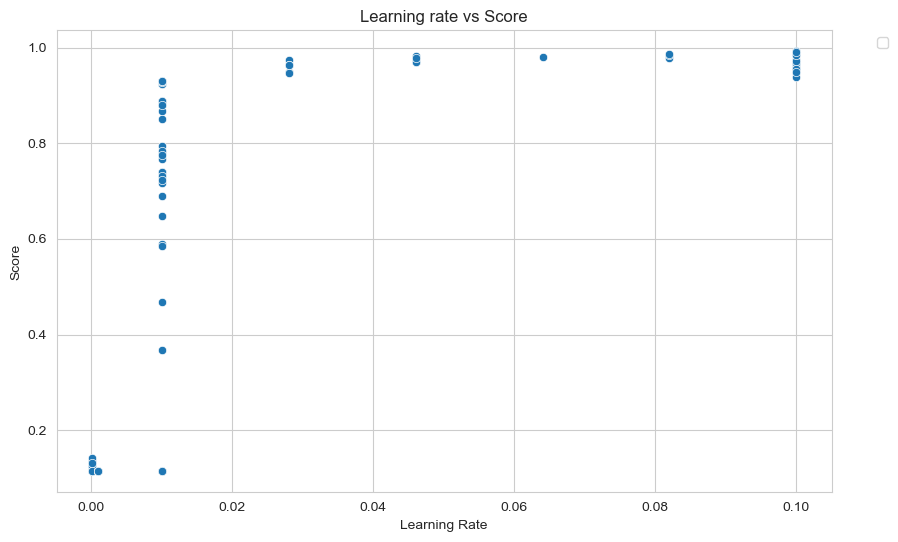

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


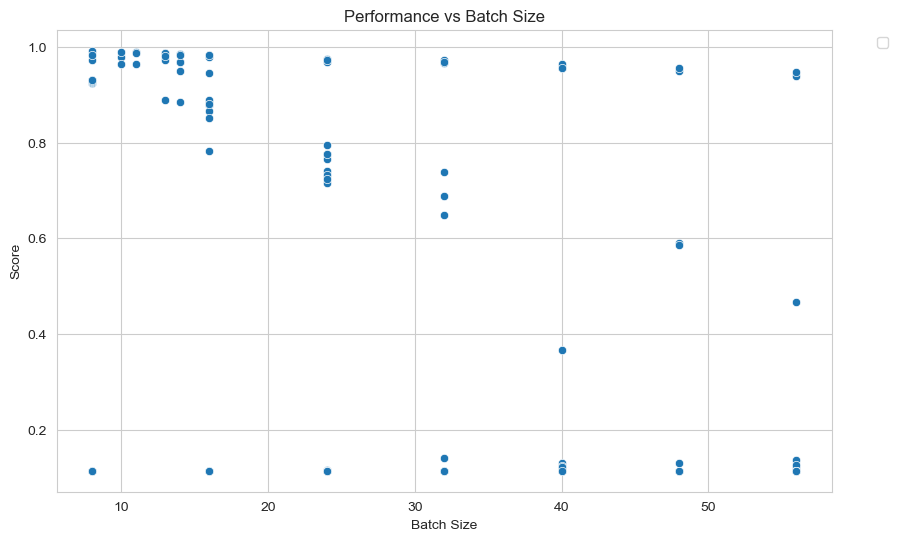

In [23]:
sns.set_style('whitegrid')

# Influence du learning rate sur le scre
plt.figure(figsize=(10, 6))
sns.scatterplot(x="lr", y="score", data=df_deep)
plt.title('Learning rate vs Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Influence du batch_size sur le score
plt.figure(figsize=(10, 6))
sns.scatterplot(x="batch_size", y="score", data=df_deep)
plt.title('Performance vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

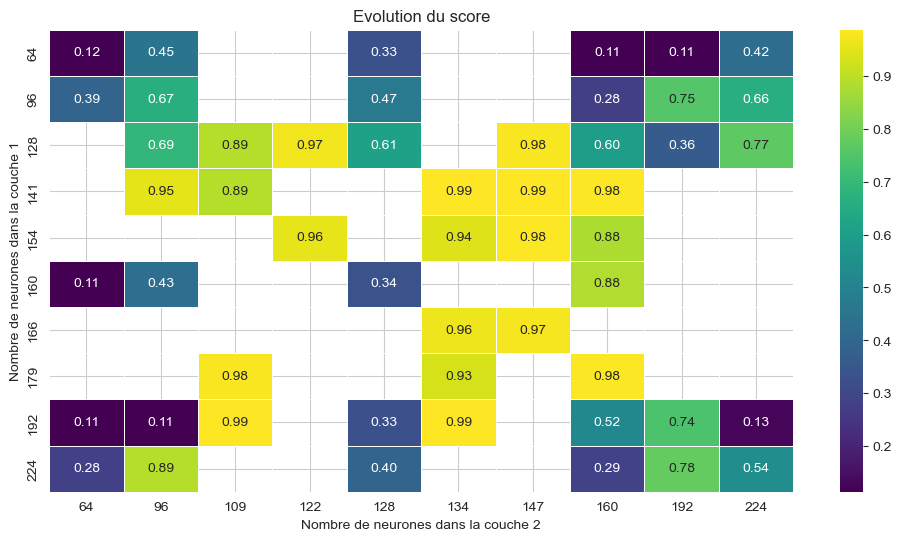

In [24]:
sns.set_style('whitegrid')

# Evolution du score par rapport au nombre de neurones des couches cachées
pivot_table = df_deep.pivot_table(values='score', index='n_hidden1', columns='n_hidden2')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Evolution du score')
plt.xlabel('Nombre de neurones dans la couche 2')
plt.ylabel('Nombre de neurones dans la couche 1')
plt.show()

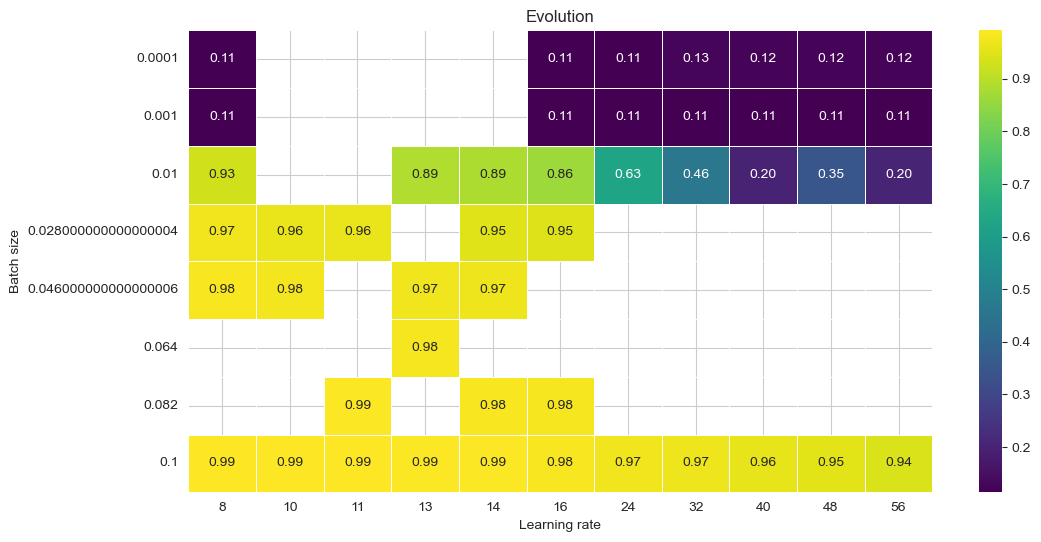

In [25]:
sns.set_style('whitegrid')

# Evolution du score par rapport au nombre de neurones des couches cachées
pivot_table = df_deep.pivot_table(values='score', index='lr', columns='batch_size')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Evolution')
plt.xlabel('Learning rate')
plt.ylabel('Batch size')
plt.show()

#### Décrire l'influence observée de chaque hyperparamètre sur la performance
Ceci nous permet donc optimiser les hyperparamètres tout en tenant compte des contraintes de calcul disponibles, le tout ayant été exécuté en 48 minutes lors de l'expérimentation avec une performance de notre meilleur modèle sur le test set s'élevant à 0.9830.

Nous observons au travers de l'évolution de la performance par rapport à la variation des hyperparamètres des tendances similaires à celles précédemment observés:
- $\eta$<br/>
On observe une amélioration du score avec l'augmentation du taux d'apprentissage. Cette augmentation est rapide à mesure que l'on passe de petites valeurs (0.0001) à des valeurs élevées (0.01) passant de 0.12 à 0.93 pour les meilleurs modèles respectifs. La tendance à l'augmentation demeurre mais est moins notable et se stabilise au delà de 0.04 où les valeurs sont aux alentours de 0.98-0.99. On peut également noter que pour des tailles de batch élevés (16+) avec des learning rate faibles les performances sont généralement mauvaises.
- Nombre de neurones des couches cachées<br/> 
Nous pouvons remarquer qu'il est nécessaire d'équilibrer le nombre de neurones dans les deux couches, en évitant les extrêmes (nombre de neurones trop bas ou trop élevés) dans les deux couches. Les meilleurs performances sont obtenues avec un nombre moyen de neurones dans la première couche (128-154) et un nombre de neurones élevés dans la deuxième couche (122-160) avec généralement entre 0.96 et 0.98 de score.<br/>
Les autres configurations entrainent des performances plus faibles particulièrement lorsque les valeurs au niveau des deux couches se trouvent sur les extrêmes (nombre de neurones trop grand ou trop petit) où les performances sont généralements mauvaises
- Batch size<br/>
On observe une tendance générale de baisse du score à mesure que la taille du batch augmente. On observe des performances élevées avec de petites tailles de batch (8-16) et le score baisse à mesure que l'on s'en éloigne bien que la dimunition ne soit pas trop prononcée.

### Partie 4 : CNN

#### Implémentez un réseau de neurones convolutif permettant d’avoir de bonnes performances. Expliquez et justifiez votre démarche

Pour implémenter notre CNN, nous nous inspirons de l'architecture LeNet5 étant donné qu'il s'agit d'un réseau simple qui a déjà démontré de hautes performances sur ce jeu de données. Ce choix est dû au fait que bien que bien que notre puissance de calcul nous permettrait probablement de fine tuner un réseau comme ResNet d'après quelques recherches faites sur le temps d'entrainement, nous serions également limité dans la quantité de personnalisation que nous pourrions apporter, raison pour laquelle nous avons opté de nous inspirer d'un réseau simple et construire notre propre CNN sur cette base.<br/>
LeNet5 est un réseau simple de 5 couches dont 2 de convolutions et 3 couches denses, nous décidons donc de suivre cette architecture de CNN en redéfinissant les paramètres des couches<br/>

- Couche 1 : Convolution avec les paramètres suivants in_channels = 1 (nos tenseurs d'entrée ont un canal), out_channels=n_out_channels1, kernel_size=3, padding=0, stride = 1 avec des tenseurs de dimension (1x28x28) en entrée, ReLU comme fonction d'activation pour le calcul des features map suivi d'un MaxPool2D avec kernel_size=2, stride=2, padding=0 pour l'undersampling<br/>
    Résultat à la sortie
    ```math
        w_{out} = h_{out} = \frac{28 - 3}{1} + 1 = 26\newline
    ```
    Après convolution nous avons donc à la sortie des tenseurs (n_out_channels1, 26, 26) que nous passons à la fonction d'activation qui ne change pas nos dimensions. Nous passons donc ensuite à la couche de MaxPool2D avec nos tenseurs d'entrées de taille (n_out_channels1, 26, 26)
    ```math
        w_{out} = h_{out} = \frac{26 - 2}{2} + 1 = 13
    ```
    Après cette étape de pooling nous avons donc à la sortie des tenseurs de dimension (n_out_channels1, 13, 13)

- Couche 2 : Convolution avec les paramètres suivants in_channels = n_out_channels1 (nos tenseurs à la sortie de la couche 1 ont ce nombre de channels), out_channels=n_out_channels2, kernel_size=3, padding=0, stride = 1 avec des tenseurs en entrée de dimension (n_out_channels1x13x13), ReLU comme fonction d'activation pour le calcul des features map suivi d'un MaxPool2D avec kernel_size=3, stride=2, padding=1 pour l'undersampling<br/>
    Résultat à la sortie
    ```math
        w_{out} = h_{out} \frac{13 - 3}{1} + 1 = 11
    ```
    Après convolution nous avons donc à la sortie des tenseurs (n_out_channels2, 11, 11) que nous passons à la fonction d'activation qui ne change pas nos dimensions. Nous passons donc ensuite à la couche de MaxPool2D avec nos tenseurs d'entrées de taille (n_out_channels2, 11, 11)
    ```math
        dim_{out} = h_{out} = \frac{11 + (2*1) - 3}{2} + 1 = 6
    ```
    Après cette étape de pooling nous avons donc à la sortie des tenseurs de dimension (n_out_channels2, 6, 6)

A la fin de ces deux convolutions, nous devons donc passer ensuite aux couches denses. Cependant avant ce passage il est nécessaire de redimensionner nos tenseurs en dépliant (flatten) la sortie de la double convolution (n_out_channels2, 6, 6) ce qui nous donne des tenseurs de dimensions 6 * 6 * n_out_channels2

- Couche 3 : Fully connected layer (Linear) avec les paramètres in_features= 6 * 6 * n_out_channels2 (correspondant à la dimension de nos tenseur flattened), out_features= n_hidden1<br/>
    A la sortie nous avons donc des tenseurs de dimension (n_hidden1,)

- Couche 4 : Fully connected layer (Linear) avec les paramètres in_features= n_hidden1(correspondant à la dimension de nos tenseurs à la sortie de la couche 3), out_features=n_hidden2<br/>
    A la sortie nous avons donc des tenseurs de dimension (n_hidden2,)

- Couche 5 : Fully connected layer (Linear) avec les paramètres in_features=n_hidden2(correspondant à la dimension de nos tenseurs à la sortie de la couche 4), out_features=10 (vecteur one hot encoded de labels)<br/>
    A la sortie nous avons donc des tenseurs de dimension (10,)

Pour la fonction de coût, nous utilisons la cross-entropy, qui est mieux adaptée à la classification multiclasse. Elle pénalise davantage le modèle pour les mauvaises prédictions que la MSE, ce qui permet une convergence plus rapide à mesure que l'on se rapproche des classes réelles. Contrairement à la MSE, qui traite toutes les erreurs de manière linéaire, la cross-entropy punit plus sévèrement les prédictions éloignées de la classe véritable, ce qui la rend plus efficace pour ce type de problème.<br/>

Certains hyperparamètres de notre modèle n'ont pas été défini, en effet nous avions initialement prévu de procéder par la méthode décrite précédemment afin de les définir. Nous avons donc 6 hyperparamètres à définir (n_out_channels1, n_out_channels2, n_hidden1, n_hidden2, $\eta$, batch_size), cependant nous nous sommes vite rendu compte que nous ne pourrions tester toutes les combinaisons avec cette approche dû à la largeur de l'espace de recherche ainsi que la complexité du modèle. A cet effet, nous avons donc décider de fixer les hyperparamètres relatifs aux canaux des couches de convolution et aux nombre de neurones des couches cachées à des valeurs similaires à ceux de LeNet, nous limitant donc à explorer pour le learning rate de 0.01 à 0.1 par pas de 0.02 et pour le batch size de 5 à 20 par pas de 5 et avons effectuer un Grid Search pour trouver les meilleurs hyperparamètres.

In [26]:
class MyCNN():
    def __init__(self, n_channels1, n_channels2, n_hidden1, n_hidden2):
        super().__init__()
        self.cnn = nn.Sequential(
            ### Première couche de convolution
            nn.Conv2d(1, n_channels1, kernel_size=3, stride=1, padding=0), # output : (n_out_channels1, 26, 26)
            nn.ReLU(), # output : (n_out_channels1, 26, 26)
            nn.MaxPool2d(kernel_size = 2, stride = 2), # output : (n_out_channels1, 13, 13)
            ### Deuxième couche de convolution
            nn.Conv2d(n_channels1, n_channels2, kernel_size=3, stride=1, padding=0), # output : (n_out_channels2, 11, 11)
            nn.ReLU(), # output : (n_out_channels2, 11, 11)
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding=1), # output : (n_out_channels2, 6, 6)
            ### Flatten du feature map 
            nn.Flatten(), # output : # output : n_out_channels2 * 6 * 6
            ### Première couche dense
            nn.Linear(n_channels2 * 6 * 6, n_hidden1), # output : n_hidden_1
            nn.ReLU(), # output : n_hidden_1
            ### Deuxième couche dense
            nn.Linear(n_hidden1, n_hidden2), # output : n_hidden_2
            nn.ReLU(), # output : n_hidden_2
            ### Couche de sortie
            nn.Linear(n_hidden2, 10)
        )

    def train(self, train_dataset, test_dataset, epochs, lr, *, batch_size=5, patience=2):
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
        # Définition de la fonction coût et de l'optimiseur
        loss_func = nn.CrossEntropyLoss()
        optim = torch.optim.SGD(self.cnn.parameters(), lr=lr)
        # Variables pour l'early stopping
        prev_acc = 0.0
        no_improve_epochs = 0
        eps = 1e-4
        # Entrainement pour le nombre d'epochs défini
        for n in range(epochs):
            # Chargement des tuples (data, label) du train set
            for x,t in train_loader:
                # Prediction et mise à jour des poids
                y = self.cnn(x)
                loss = loss_func(y, torch.argmax(t,1))
                loss.backward()
                optim.step()
                optim.zero_grad()
            # Evaluation lors de l'apprentissage
            acc = 0.
            count = 0
            # Chargement des tuples (data, label) du test set
            with torch.no_grad():
                for x,t in test_loader:
                    # Prediction et mise à de l'accuracy
                    y = self.cnn(x)
                    acc += torch.argmax(y,1) == torch.argmax(t,1)
                    count += 1
                current_acc = acc/count
                # --------------------------------------------------------------------------------------------  #
                # Early stopping nous permet d'arrêter l'entraînement d'un modèle lorsque les perfomances       #
                # cessent de s'améliorer sur un certain nombre d'epochs consécutifs (patience) afin d'éviter    #
                # l'overfitting et économiser en terme de ressources de calcul                                  #
                # --------------------------------------------------------------------------------------------  #
                if (current_acc-prev_acc) > eps:
                    no_improve_epochs = 0 
                else:
                    no_improve_epochs += 1
                prev_acc = current_acc
                if no_improve_epochs >= patience:
                    break
        # Renvoie du pourcentage de bonnes réponses
        return acc/count

In [27]:
# Création des dictionnaires avec les valeurs possibles pour chaque hyperparamètre
param_grid = dict()

param_grid['lr'] = np.arange(0.01,0.1,0.02)
param_grid['batch_size'] = list(range(5,20,5))
param_grid['n_channels1'] = [6]
param_grid['n_channels2'] = [16]
param_grid['n_hidden1'] = [128]
param_grid['n_hidden2'] = [84]

# Création de la grille de paramètres (Liste de toutes les combinaisons de valeurs possibles)
all_combinations = list(ParameterGrid(param_grid))
print(f"Nous avons {len(all_combinations)} combinaisons d'hyperparamètres")

Nous avons 15 combinaisons d'hyperparamètres


In [28]:
# Redimmension des données tests et données d'entrainement pour les adapter à l'entrée attendu par l'input layer
data_train = torch.reshape(data_train, (-1, 1, 28, 28))
data_test = torch.reshape(data_test, (-1, 1, 28, 28))

# Séparation des données du train set initial en train (80%) et validation set (20%)
train_data, val_data, train_labels, val_labels = train_test_split(data_train, label_train, test_size=.2)

# Création du train set et du validation set
train_dataset = torch.utils.data.TensorDataset(data_train,label_train)
val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)

# Création du test set
test_dataset = torch.utils.data.TensorDataset(data_test, label_test)

In [29]:
# Initialisation de la liste pour stocker les résultats des diverses combinaisons
data = []

# Initialisation du best_score et du best_model
best_score = 0
best_model = None

# Test de toutes les combinaisons de valeurs obtenues
for combination in all_combinations:
    # Initialisation du model avec les params de la combinaison
    model = MyCNN(combination['n_channels1'], combination['n_channels2'], combination['n_hidden1'], combination['n_hidden2'])
    # Entrainement du model avec les params de la combinaison
    score = model.train(train_dataset, val_dataset, 10, combination['lr'], batch_size=combination['batch_size'])
    # Ajout des résultats obtenus avec cette combinaison à liste des résultats
    combination['score'] = round(float(score[0]), 4)
    data.append(combination)
    # Mise à jour du meilleur modèle et score obtenu s'il y a lieu
    if score > best_score:
        best_score = score
        best_model = model

In [30]:
# Création d'un dataframe à partir de la liste des résultats pour visualisation
df_cnn = pd.DataFrame(data)
df_cnn.head(10)

,batch_size,lr,n_channels1,n_channels2,n_hidden1,n_hidden2,score
0,5,0.01,6,16,128,84,0.9963
1,5,0.03,6,16,128,84,0.9984
2,5,0.05,6,16,128,84,0.9854
3,5,0.07,6,16,128,84,0.9846
4,5,0.09,6,16,128,84,0.9513
5,10,0.01,6,16,128,84,0.9940
6,10,0.03,6,16,128,84,0.9980
7,10,0.05,6,16,128,84,0.9901
8,10,0.07,6,16,128,84,0.9952
9,10,0.09,6,16,128,84,0.9960


In [31]:
# Affichage de la combinaison d'hyperparamètres présentation le meilleur score
best_combination = df_cnn.iloc[df_cnn['score'].idxmax()]
print(f"La meilleure combinaison d'hyperparamètres est\n {best_combination}")

La meilleure combinaison d'hyperparamètres est
 batch_size       5.0000
lr               0.0300
n_channels1      6.0000
n_channels2     16.0000
n_hidden1      128.0000
n_hidden2       84.0000
score            0.9984
Name: 1, dtype: float64


In [32]:
# Vérification de la précision du meilleur modèle obtenu sur le test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
acc = 0.
count = 0
with torch.no_grad():
    for x,t in test_loader:
        y = best_model.cnn(x)
        acc += torch.argmax(y,1) == torch.argmax(t,1)
        count += 1
    test_score = acc/count
print(f"La précision du meilleur modèle sur le test set est: {test_score[0]:.4f}")

La précision du meilleur modèle sur le test set est: 0.9909


In [33]:
# Affichage du modèle 
summary(best_model.cnn, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 26, 26]           60
├─ReLU: 1-2                              [-1, 6, 26, 26]           --
├─MaxPool2d: 1-3                         [-1, 6, 13, 13]           --
├─Conv2d: 1-4                            [-1, 16, 11, 11]          880
├─ReLU: 1-5                              [-1, 16, 11, 11]          --
├─MaxPool2d: 1-6                         [-1, 16, 6, 6]            --
├─Flatten: 1-7                           [-1, 576]                 --
├─Linear: 1-8                            [-1, 128]                 73,856
├─ReLU: 1-9                              [-1, 128]                 --
├─Linear: 1-10                           [-1, 84]                  10,836
├─ReLU: 1-11                             [-1, 84]                  --
├─Linear: 1-12                           [-1, 10]                  850
Total params: 86,482
Trainable params: 86,482
Non-trainable params: 0
Total

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 26, 26]           60
├─ReLU: 1-2                              [-1, 6, 26, 26]           --
├─MaxPool2d: 1-3                         [-1, 6, 13, 13]           --
├─Conv2d: 1-4                            [-1, 16, 11, 11]          880
├─ReLU: 1-5                              [-1, 16, 11, 11]          --
├─MaxPool2d: 1-6                         [-1, 16, 6, 6]            --
├─Flatten: 1-7                           [-1, 576]                 --
├─Linear: 1-8                            [-1, 128]                 73,856
├─ReLU: 1-9                              [-1, 128]                 --
├─Linear: 1-10                           [-1, 84]                  10,836
├─ReLU: 1-11                             [-1, 84]                  --
├─Linear: 1-12                           [-1, 10]                  850
Total params: 86,482
Trainable params: 86,482
Non-trainable params: 0
Total

Nous avons ainsi testé 15 combinaisons en 37 minutes avec une performance de notre meilleur modèle égale à 0.9909 sur le test set.